
# Scaling the regularization parameter for SVCs

The following example illustrates the effect of scaling the regularization
parameter when using `svm` for `classification <svm_classification>`.
For SVC classification, we are interested in a risk minimization for the
equation:


\begin{align}C \sum_{i=1, n} \mathcal{L} (f(x_i), y_i) + \Omega (w)\end{align}

where

- $C$ is used to set the amount of regularization
- $\mathcal{L}$ is a `loss` function of our samples and our model parameters.
- $\Omega$ is a `penalty` function of our model parameters

If we consider the loss function to be the individual error per sample, then the
data-fit term, or the sum of the error for each sample, increases as we add more
samples. The penalization term, however, does not increase.

When using, for example, `cross validation <cross_validation>`, to set the
amount of regularization with `C`, there would be a different amount of samples
between the main problem and the smaller problems within the folds of the cross
validation.

Since the loss function dependens on the amount of samples, the latter
influences the selected value of `C`. The question that arises is "How do we
optimally adjust C to account for the different amount of training samples?"


## Data generation

In this example we investigate the effect of reparametrizing the regularization
parameter `C` to account for the number of samples when using either L1 or L2
penalty. For such purpose we create a synthetic dataset with a large number of
features, out of which only a few are informative. We therefore expect the
regularization to shrink the coefficients towards zero (L2 penalty) or exactly
zero (L1 penalty).



In [1]:
from sklearn.datasets import make_classification

n_samples, n_features = 100, 300
X, y = make_classification(
    n_samples=n_samples, n_features=n_features, n_informative=5, random_state=1
)

## L1-penalty case
In the L1 case, theory says that provided a strong regularization, the
estimator cannot predict as well as a model knowing the true distribution
(even in the limit where the sample size grows to infinity) as it may set some
weights of otherwise predictive features to zero, which induces a bias. It does
say, however, that it is possible to find the right set of non-zero parameters
as well as their signs by tuning `C`.

We define a linear SVC with the L1 penalty.



In [2]:
from sklearn.svm import LinearSVC

model_l1 = LinearSVC(penalty="l1", loss="squared_hinge", dual=False, tol=1e-3)

We compute the mean test score for different values of `C` via
cross-validation.



In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import ShuffleSplit, validation_curve

Cs = np.logspace(-2.3, -1.3, 10)
train_sizes = np.linspace(0.3, 0.7, 3)
labels = [f"fraction: {train_size}" for train_size in train_sizes]
shuffle_params = {
    "test_size": 0.3,
    "n_splits": 150,
    "random_state": 1,
}

results = {"C": Cs}
for label, train_size in zip(labels, train_sizes):
    cv = ShuffleSplit(train_size=train_size, **shuffle_params)
    train_scores, test_scores = validation_curve(
        model_l1,
        X,
        y,
        param_name="C",
        param_range=Cs,
        cv=cv,
        n_jobs=2,
    )
    results[label] = test_scores.mean(axis=1)
results = pd.DataFrame(results)

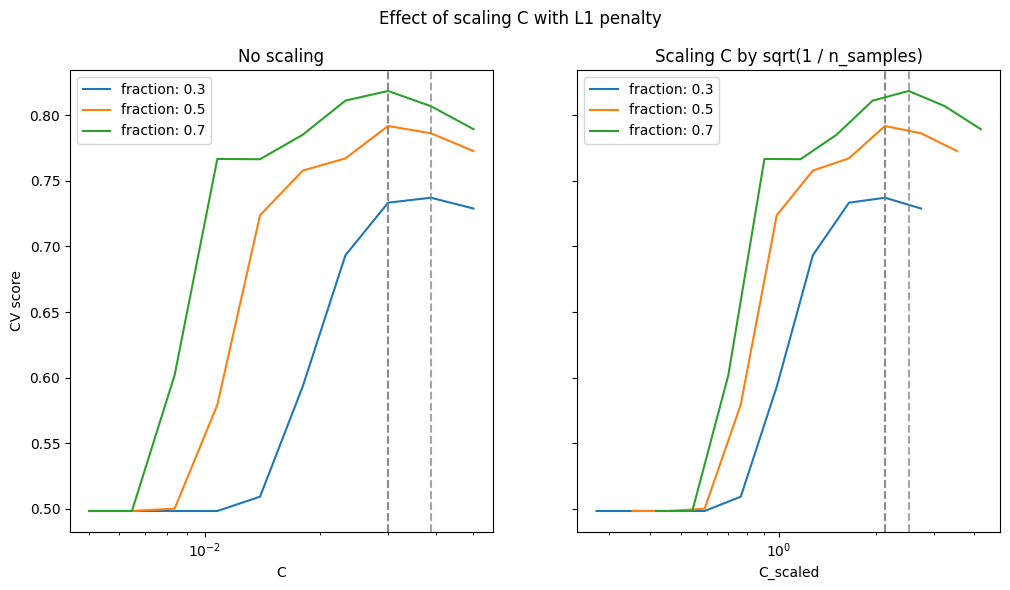

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# plot results without scaling C
results.plot(x="C", ax=axes[0], logx=True)
axes[0].set_ylabel("CV score")
axes[0].set_title("No scaling")

for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    axes[0].axvline(x=best_C, linestyle="--", color="grey", alpha=0.7)

# plot results by scaling C
for train_size_idx, label in enumerate(labels):
    train_size = train_sizes[train_size_idx]
    results_scaled = results[[label]].assign(
        C_scaled=Cs * float(n_samples * np.sqrt(train_size))
    )
    results_scaled.plot(x="C_scaled", ax=axes[1], logx=True, label=label)
    best_C_scaled = results_scaled["C_scaled"].loc[results[label].idxmax()]
    axes[1].axvline(x=best_C_scaled, linestyle="--", color="grey", alpha=0.7)

axes[1].set_title("Scaling C by sqrt(1 / n_samples)")

_ = fig.suptitle("Effect of scaling C with L1 penalty")

In the region of small `C` (strong regularization) all the coefficients
learned by the models are zero, leading to severe underfitting. Indeed, the
accuracy in this region is at the chance level.

Using the default scale results in a somewhat stable optimal value of `C`,
whereas the transition out of the underfitting region depends on the number of
training samples. The reparametrization leads to even more stable results.

See e.g. theorem 3 of :arxiv:`On the prediction performance of the Lasso
<1402.1700>` or :arxiv:`Simultaneous analysis of Lasso and Dantzig selector
<0801.1095>` where the regularization parameter is always assumed to be
proportional to 1 / sqrt(n_samples).

## L2-penalty case
We can do a similar experiment with the L2 penalty. In this case, the
theory says that in order to achieve prediction consistency, the penalty
parameter should be kept constant as the number of samples grow.



In [5]:
model_l2 = LinearSVC(penalty="l2", loss="squared_hinge", dual=True)
Cs = np.logspace(-8, 4, 11)

labels = [f"fraction: {train_size}" for train_size in train_sizes]
results = {"C": Cs}
for label, train_size in zip(labels, train_sizes):
    cv = ShuffleSplit(train_size=train_size, **shuffle_params)
    train_scores, test_scores = validation_curve(
        model_l2,
        X,
        y,
        param_name="C",
        param_range=Cs,
        cv=cv,
        n_jobs=2,
    )
    results[label] = test_scores.mean(axis=1)
results = pd.DataFrame(results)

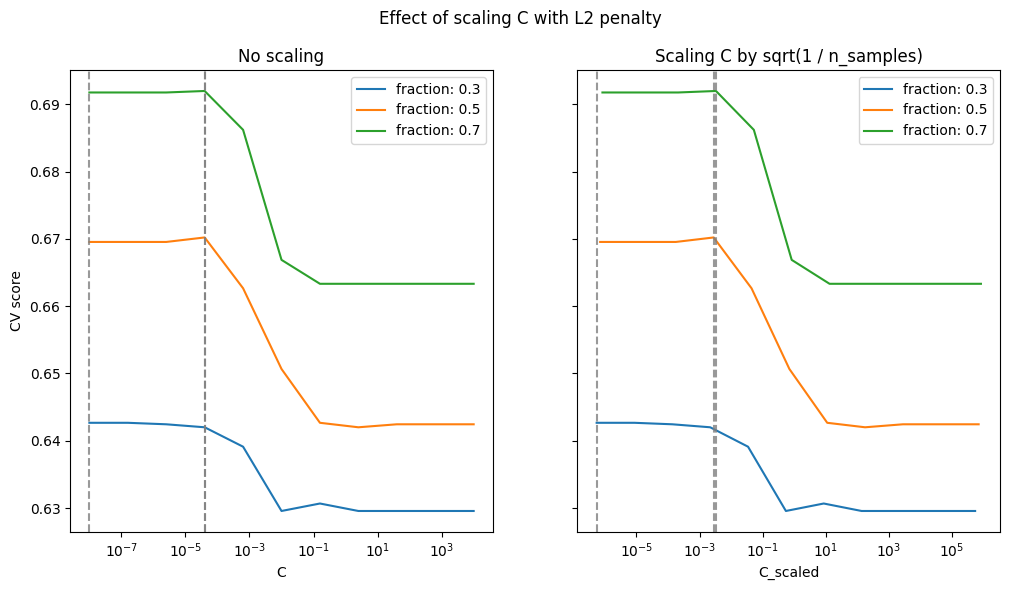

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# plot results without scaling C
results.plot(x="C", ax=axes[0], logx=True)
axes[0].set_ylabel("CV score")
axes[0].set_title("No scaling")

for label in labels:
    best_C = results.loc[results[label].idxmax(), "C"]
    axes[0].axvline(x=best_C, linestyle="--", color="grey", alpha=0.8)

# plot results by scaling C
for train_size_idx, label in enumerate(labels):
    results_scaled = results[[label]].assign(
        C_scaled=Cs * float(n_samples * np.sqrt(train_sizes[train_size_idx]))
    )
    results_scaled.plot(x="C_scaled", ax=axes[1], logx=True, label=label)
    best_C_scaled = results_scaled["C_scaled"].loc[results[label].idxmax()]
    axes[1].axvline(x=best_C_scaled, linestyle="--", color="grey", alpha=0.8)
axes[1].set_title("Scaling C by sqrt(1 / n_samples)")

fig.suptitle("Effect of scaling C with L2 penalty")
plt.show()

For the L2 penalty case, the reparametrization seems to have a smaller impact
on the stability of the optimal value for the regularization. The transition
out of the overfitting region occurs in a more spread range and the accuracy
does not seem to be degraded up to chance level.

Try increasing the value to `n_splits=1_000` for better results in the L2
case, which is not shown here due to the limitations on the documentation
builder.

